# NN matrix decomposition for movie similarities

How can we apply SVD to find similarities between movies?

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl

plt.style.use("seaborn-v0_8-whitegrid")

### TF IDF (Term Frequency-Inverse Document Frequency)

This gives each document a weight for each member in a vocab.
The vocab represents all words across all documents (the corpus).

The weights represent the frequent of the word in the document relative to the frequency of that word in the corpus.
Common words like 'is' get a low weighting as they are common in the corpus.
The weights are higher for uncommon words.

$$
\mathrm {tf} (t,d)={\frac {f_{t,d}}{\sum _{t'\in d}{f_{t',d}}}},
$$

where $f_{t,d}$ is the count of token $t$ in document $d$ and $\sum _{t'\in d}{f_{t',d}}$ is the count of all tokens in the document.

$$
\mathrm {idf} (t,D)=\log {\frac {N}{|\{d\in D:t\in d\}|}},
$$

where $N$ is the count of documents $D$ and $|\{d\in D:t\in d\}|$ is count of documents where the term $t$ appears.

The final TF-IDF is the product of the two:

$$
\mathrm {tfidf} (t,d,D)=\mathrm {tf} (t,d)\cdot \mathrm {idf} (t,D)
$$

We make a trivial example below. We have a vocabulary of 4 tokens and we inflate the token `a1` to make it common.
In the TF-IDF vectors we see that the `a1` values are lower than `b2` and `c3` as `a1` is commonly represented in the corpus.
*Note: the `TfidfVectorizer` normalises values by default.*

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

documents = [
    "a1 b2 c3",
    "b2 c3",
    "c3 b2 a1",  # order is not relevant
    "d4",
]
documents.extend(["a1"] * 100)  # artificially make a1 very common

vectorizer = TfidfVectorizer(norm=None)
tfidf_matrix = vectorizer.fit_transform(documents)

print("TF-IDF Matrix (dense representation) (documents x vocab size):")
df = pl.DataFrame(tfidf_matrix.toarray())
df.columns = vectorizer.get_feature_names_out()
display(df)

TF-IDF Matrix (dense representation) (documents x vocab size):


a1,b2,c3,d4
f64,f64,f64,f64
1.019231,4.267666,4.267666,0.0
0.0,4.267666,4.267666,0.0
1.019231,4.267666,4.267666,0.0
0.0,0.0,0.0,4.960813
1.019231,0.0,0.0,0.0
…,…,…,…
1.019231,0.0,0.0,0.0
1.019231,0.0,0.0,0.0
1.019231,0.0,0.0,0.0


### Applying to MovieLens

We will apply the idea of TF-IDF to find similarities across movies, taken from the MovieLens dataset.
In the dataset each movie is associated with a list of genres.
Multiple genres are listed for each movie in the dataset.
Find similarity across movies by comparing their genres.
Movies with the same genre list are more meaningfully related if those genre lists are rare.
Movies with the same genre list that are common are not necessarily related closely.

Movie genres are given as follows:

In [10]:
import utilities

ratings_df = utilities.load_ratings()
ratings_df

userId,movieId,rating,timestamp
i64,i64,f64,i64
1,5952,4.0,1147868053
1,2012,2.5,1147868068
1,2011,2.5,1147868079
1,1653,4.0,1147868097
1,1250,4.0,1147868414
…,…,…,…
162541,1259,4.5,1240953609
162541,1266,5.0,1240953613
162541,1556,1.0,1240953650


In [11]:
ratings_df['rating'].describe()

statistic,value
str,f64
"""count""",2.5000095e7
"""null_count""",0.0
"""mean""",3.533854
"""std""",1.060744
"""min""",0.5
"""25%""",3.0
"""50%""",3.5
"""75%""",4.0
"""max""",5.0


In [13]:
import torch
import torch.nn as nn


class MovieEmbeddingModel(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim):
        super(MovieEmbeddingModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.max_rating = 5.0
        self.min_rating = 0.5

    def forward(self, user_ids, movie_ids):
        user_vecs = self.user_embedding(user_ids)
        movie_vecs = self.movie_embedding(movie_ids)
        rating = (user_vecs * movie_vecs).sum(dim=1)

        # adding a bias term to account for the fact that some users are more critical than others
        # rating = (user_vecs * movie_vecs).sum(dim=1) + self.user_bias(user_ids).squeeze() + self.movie_bias(movie_ids).squeeze()

        rating = (
            torch.sigmoid((user_vecs * movie_vecs).sum(dim=1))
            * (self.max_rating - self.min_rating)
            + self.min_rating
        )

        return rating


# Initialize model
model = MovieEmbeddingModel(num_users=1000, num_movies=5000, embedding_dim=5)

# Example usage
user_ids = torch.tensor([1, 2, 3])
movie_ids = torch.tensor([101, 102, 103])
rating = model(user_ids, movie_ids)  # Get movie embeddings

user_ids = torch.tensor([1, 2, 3, 4])  # Batch of user IDs
movie_ids = torch.tensor([101, 102, 103, 104])  # Corresponding movie IDs
ratings = model(user_ids, movie_ids)  # Process in a single forward pass
ratings

tensor([2.8305, 0.5932, 2.2527, 0.5798], grad_fn=<AddBackward0>)

In [8]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset

# Dataset for user-movie interactions
class MovieDataset(Dataset):
    def __init__(self, user_ids, movie_ids, ratings):
        self.user_ids = torch.tensor(user_ids, dtype=torch.long)
        self.movie_ids = torch.tensor(movie_ids, dtype=torch.long)
        self.ratings = torch.tensor(ratings, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return {
            'user_id': self.user_ids[idx],
            'movie_id': self.movie_ids[idx],
            'rating': self.ratings[idx]
        }

# Lightning Module for the Movie Embedding Model
class MovieEmbeddingModel(pl.LightningModule):
    def __init__(self, num_users, num_movies, embedding_dim, reg_lambda=0.01, lr=0.001):
        super(MovieEmbeddingModel, self).__init__()
        self.save_hyperparameters()
        
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)
        self.reg_lambda = reg_lambda
        self.lr = lr
        
        # Initialize weights
        nn.init.normal_(self.user_embedding.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.movie_embedding.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.movie_bias.weight)

    def forward(self, user_ids, movie_ids):
        user_vecs = self.user_embedding(user_ids)
        movie_vecs = self.movie_embedding(movie_ids)
        user_b = self.user_bias(user_ids).squeeze()
        movie_b = self.movie_bias(movie_ids).squeeze()
        rating = (user_vecs * movie_vecs).sum(dim=1) + user_b + movie_b
        return rating

    def regularization_loss(self):
        # L2 regularization
        return self.reg_lambda * (
            self.user_embedding.weight.norm(2) +
            self.movie_embedding.weight.norm(2)
        )

    def training_step(self, batch, batch_idx):
        user_ids = batch['user_id']
        movie_ids = batch['movie_id']
        ratings = batch['rating']
        
        predictions = self.forward(user_ids, movie_ids)
        mse_loss = nn.functional.mse_loss(predictions, ratings)
        reg_loss = self.regularization_loss()
        loss = mse_loss + reg_loss

        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        user_ids = batch['user_id']
        movie_ids = batch['movie_id']
        ratings = batch['rating']
        
        predictions = self.forward(user_ids, movie_ids)
        mse_loss = nn.functional.mse_loss(predictions, ratings)
        self.log("val_loss", mse_loss, prog_bar=True, logger=True)
        return mse_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Sample data (replace with your dataset)
user_ids = [0, 1, 2, 3, 4]
movie_ids = [10, 20, 30, 40, 50]
ratings = [4.0, 3.5, 5.0, 4.5, 3.0]

# Dataset and DataLoaders
train_dataset = MovieDataset(user_ids, movie_ids, ratings)
val_dataset = MovieDataset(user_ids, movie_ids, ratings)  # Use a different dataset for validation

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)

# Initialize the model and trainer
model = MovieEmbeddingModel(num_users=100, num_movies=100, embedding_dim=5, reg_lambda=0.01, lr=0.001)

trainer = pl.Trainer(max_epochs=10, accelerator='auto', devices='auto')
trainer.fit(model, train_loader, val_loader)


Parameter containing:
tensor([[-1.0901, -1.0412, -0.0749, -0.1886, -0.0757],
        [-0.6797, -0.4852,  1.4329,  1.1916, -0.1368],
        [ 1.2416,  0.6970, -0.4050, -0.3584,  1.3013],
        ...,
        [-0.5852,  0.0380, -0.0891,  0.2881, -0.8778],
        [-0.0872,  0.4455, -0.3963,  1.8504,  1.9142],
        [-1.3777,  0.5676, -0.2828,  0.0732,  0.9064]], requires_grad=True)

In [5]:
user_vecs.shape

torch.Size([3, 50])

This doesn't work well here as we can't explicitly make the user x movie matrix as the dataset is too large to fit in memory.

In [7]:
ratings_df['userId'].n_unique(), ratings_df['movieId'].n_unique()

(162541, 59047)

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Create user-movie matrix
user_movie_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# # Apply SVD for movie embeddings
# svd = TruncatedSVD(n_components=50)
# movie_embeddings = svd.fit_transform(user_movie_matrix.T)  # Transpose to get movie embeddings


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_98729/2793291299.py:4: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  user_movie_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)


Fit vectorizer to get TF-IDF values across the 24 genres.

In [4]:
vectorizer = TfidfVectorizer()
vectorizer.fit(movies_df["genres"])

print("Vocab")
print(vectorizer.vocabulary_)

Vocab
{'adventure': 1, 'animation': 2, 'children': 3, 'comedy': 4, 'fantasy': 8, 'romance': 19, 'drama': 7, 'action': 0, 'crime': 5, 'thriller': 21, 'horror': 12, 'mystery': 16, 'sci': 20, 'fi': 9, 'imax': 13, 'documentary': 6, 'war': 22, 'musical': 15, 'western': 23, 'film': 10, 'noir': 18, 'no': 17, 'genres': 11, 'listed': 14}


We will limit our analysis to the top 50 movies to make things faster and easier.

In [5]:
import utilities

ratings_df = utilities.load_ratings()
top_movie_ids = utilities.get_most_frequent_movies(ratings_df)
top_movies_df = movies_df.join(top_movie_ids, on="movieId", how="inner")

We get the TF-IDF vectors for each of those movies.

In [6]:
tfidf_matrix = vectorizer.transform(top_movies_df["genres"])
tf_idf = pl.DataFrame(tfidf_matrix.toarray())
tf_idf.columns = vectorizer.get_feature_names_out()
display(tf_idf)

action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,film,genres,horror,imax,listed,musical,mystery,no,noir,romance,sci,thriller,war,western
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.446566,0.48833,0.488084,0.277717,0.0,0.0,0.0,0.496748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.519453,0.0,0.0,0.0,0.0,0.0,0.0,0.547243,0.0,0.0,0.0,0.519453,0.401075,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.806571,0.0,0.0,0.0,0.0,0.591137,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.566703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.664551,0.0,0.0,0.0,0.0,0.487051,0.0,0.0
0.54055,0.0,0.0,0.0,0.0,0.0,0.0,0.325614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.775745,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.0,0.668545,0.0,0.0,0.0,0.0,0.0,0.0,0.743672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.668545,0.0,0.0,0.0,0.0,0.0,0.0,0.743672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.471902,0.557946,0.0,0.0,0.0,0.0,0.0,0.284261,0.620645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We note that on the first movie we have a genre of movies 'Adventure|Animation|Children|Comedy|Fantasy'.
The TF-IDF vector represents each of these genres based on their frequency in the corpus of all movies.
Therefore a popular genre like comedy get a lower value than fantasy.

We will measure similarity across movies using cosine similarity, which measures the difference in the cosine of the angle between the vectors of each movie pairing.

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tf_idf)
# limit to lower triangle only
similarity_matrix[np.triu_indices(similarity_matrix.shape[0], k=0)] = np.nan

We then plot the similarities for all 50x50 pairs.

/Users/rich/Developer/Github/VariousDataAnalysis/neural_networks/unfinished-movie_similarity/utilities.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


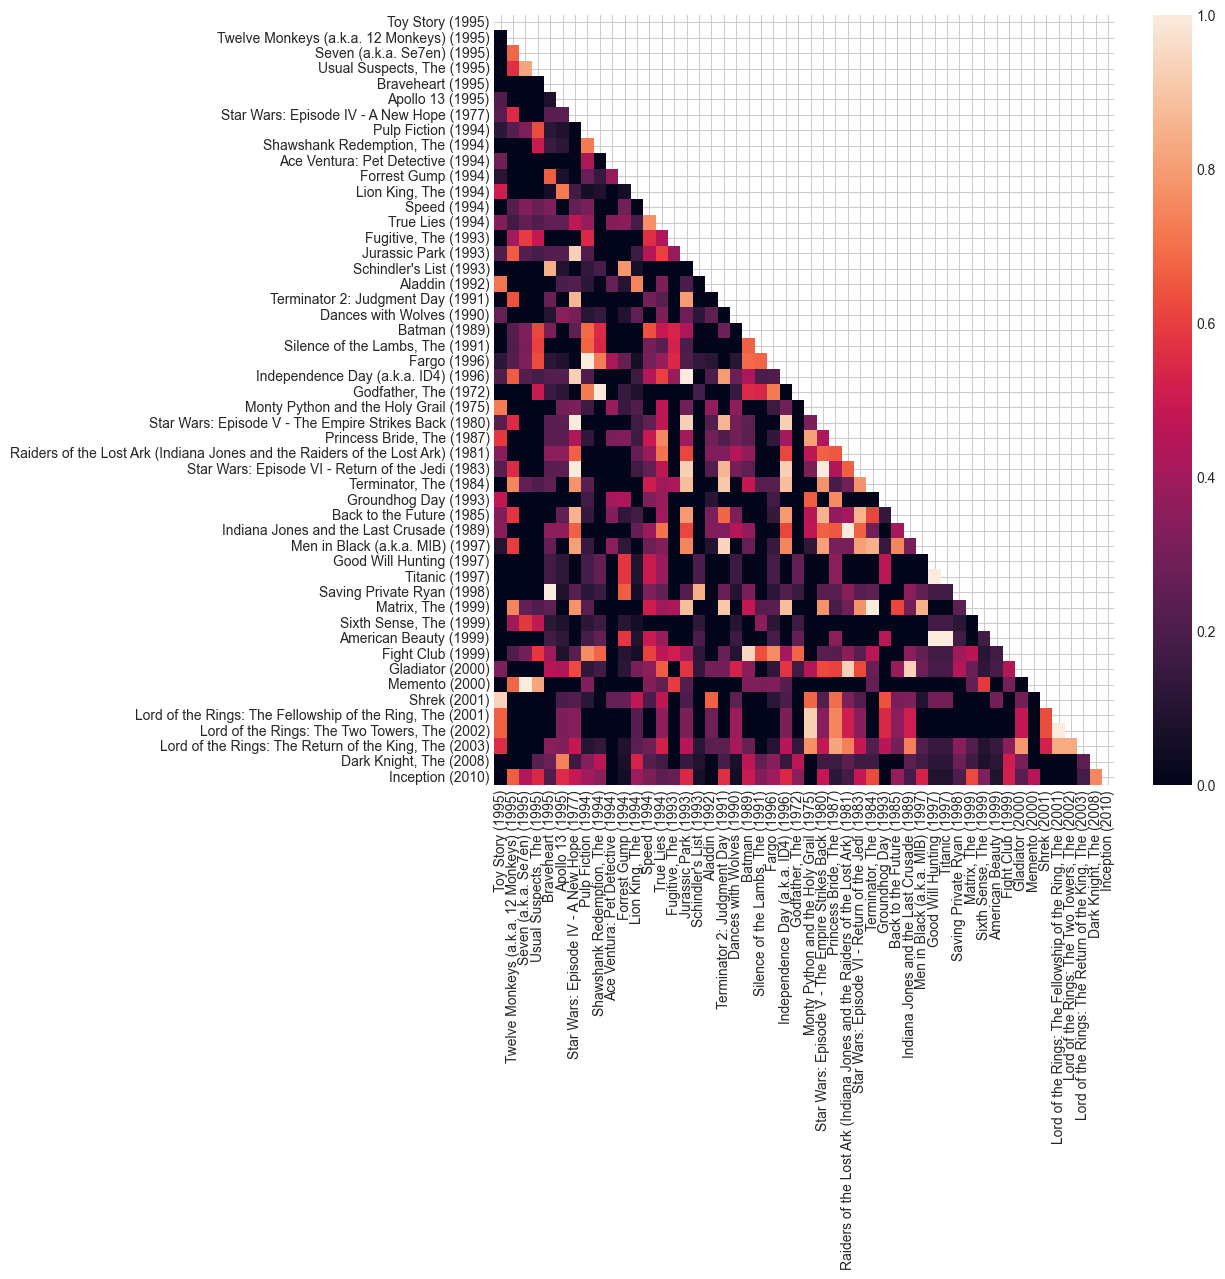

In [8]:
labels = top_movies_df["title"].to_list()
utilities.plot_similarities(
    similarity_matrix=similarity_matrix, labels=labels
)

The strongest and weakest similarities make some sense here.

In [9]:
utilities.get_extreme_similarities(similarity_matrix=similarity_matrix, labels=labels)

Most similar:
1.00 - Saving Private Ryan (1998), Braveheart (1995)
1.00 - Star Wars: Episode V - The Empire Strikes Back (1980), Star Wars: Episode IV - A New Hope (1977)
1.00 - Star Wars: Episode VI - Return of the Jedi (1983), Star Wars: Episode IV - A New Hope (1977)
1.00 - Fargo (1996), Pulp Fiction (1994)
1.00 - Star Wars: Episode VI - Return of the Jedi (1983), Star Wars: Episode V - The Empire Strikes Back (1980)

Least similar:
0.00 - Twelve Monkeys (a.k.a. 12 Monkeys) (1995), Toy Story (1995)
0.00 - Good Will Hunting (1997), Star Wars: Episode V - The Empire Strikes Back (1980)
0.00 - Good Will Hunting (1997), Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
0.00 - Good Will Hunting (1997), Star Wars: Episode VI - Return of the Jedi (1983)
0.00 - Good Will Hunting (1997), Terminator, The (1984)


If we want to use the TF-IDF vector as an embedding its not entirely suitable.
The TF-IDF vector dimension is a function here of the number of genres.
So if the number of genres goes up so does our vector.
We can use PCA to ensure the dimension of the embedding is fixed.

Here we limit to an embedding size of 5.

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
movie_embeddings = pca.fit_transform(tfidf_matrix.toarray())
movie_embeddings[:4]

array([[ 0.26407289, -0.54674565, -0.38404016, -0.08910036, -0.14765967],
       [-0.01218075,  0.61137931, -0.1809349 , -0.47297639, -0.27672617],
       [-0.4374161 ,  0.27504172, -0.42177443, -0.38369993, -0.08590811],
       [-0.61721769,  0.28347689, -0.45075525, -0.0403723 , -0.03846642]])

We loose some detail in the similarities.

/Users/rich/Developer/Github/VariousDataAnalysis/neural_networks/unfinished-movie_similarity/utilities.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


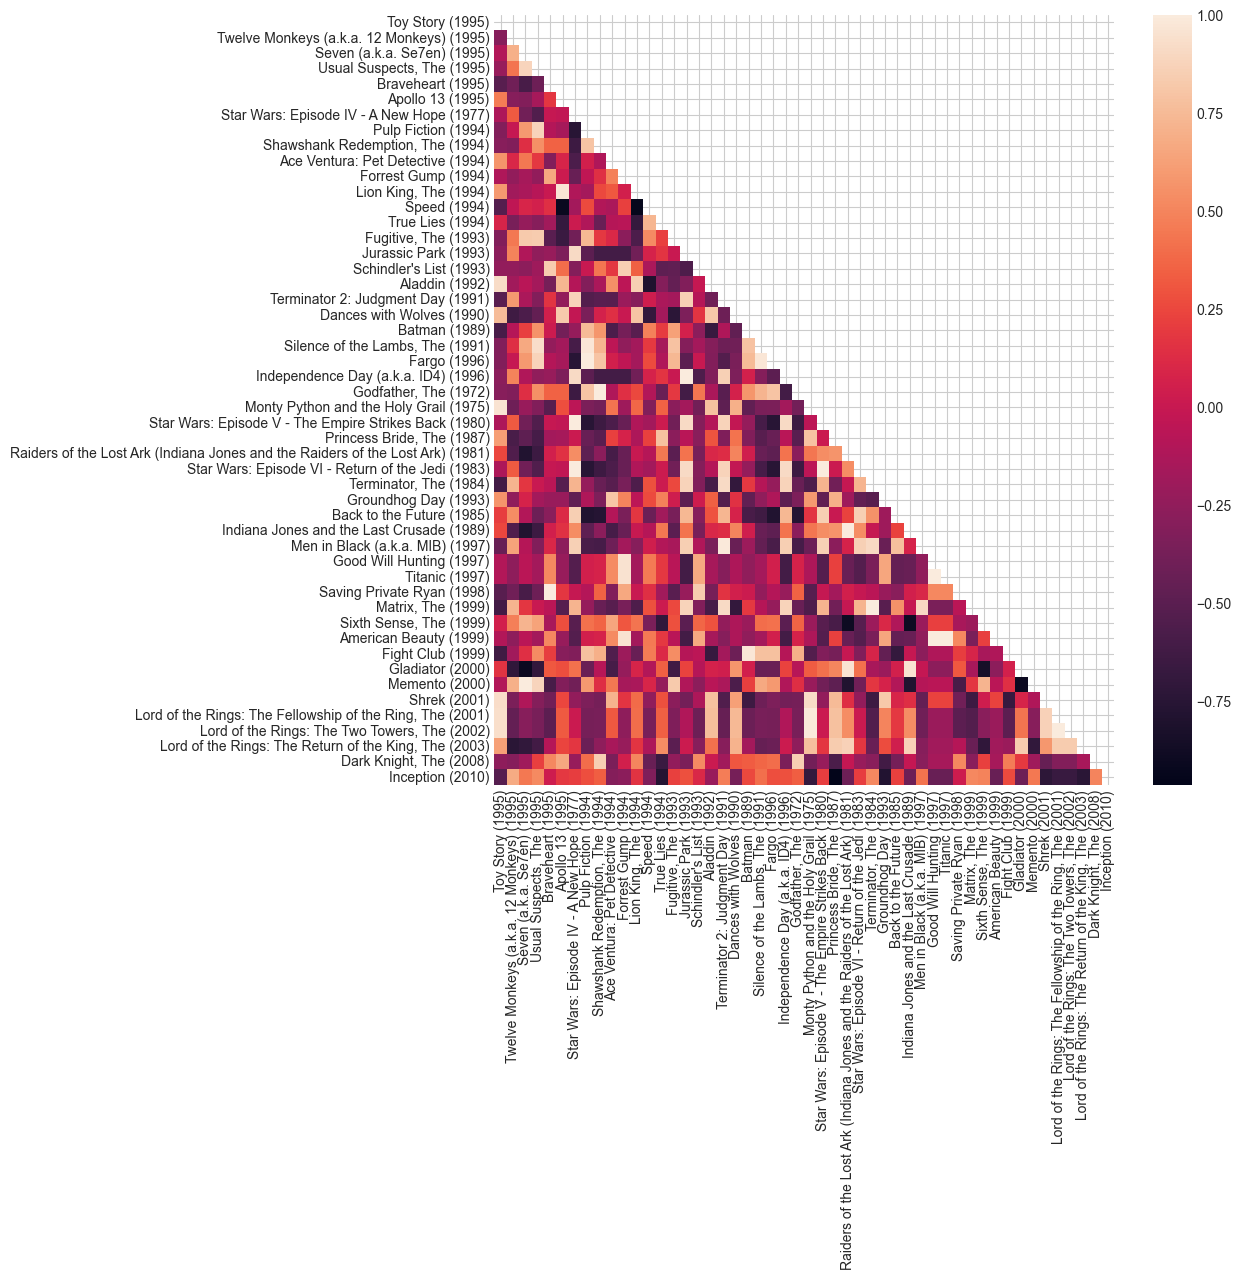

In [11]:
similarity_matrix = cosine_similarity(movie_embeddings)
similarity_matrix[np.triu_indices(similarity_matrix.shape[0], k=0)] = np.nan

utilities.plot_similarities(
    similarity_matrix=similarity_matrix, labels=top_movies_df["title"].to_list()
)

Extreme of the similarities look reasonable as before.

In [12]:
utilities.get_extreme_similarities(similarity_matrix=similarity_matrix, labels=labels)

Most similar:
1.00 - Godfather, The (1972), Shawshank Redemption, The (1994)
1.00 - Saving Private Ryan (1998), Braveheart (1995)
1.00 - Memento (2000), Seven (a.k.a. Se7en) (1995)
1.00 - Star Wars: Episode V - The Empire Strikes Back (1980), Star Wars: Episode IV - A New Hope (1977)
1.00 - Lord of the Rings: The Two Towers, The (2002), Lord of the Rings: The Fellowship of the Ring, The (2001)

Least similar:
-0.96 - Inception (2010), Princess Bride, The (1987)
-0.94 - Speed (1994), Lion King, The (1994)
-0.91 - Speed (1994), Apollo 13 (1995)
-0.91 - Gladiator (2000), Seven (a.k.a. Se7en) (1995)
-0.91 - Memento (2000), Gladiator (2000)


We will apply this method to all the movies to use at a later date.

In [13]:
from pathlib import Path

tfidf_matrix = vectorizer.transform(movies_df["genres"])
pca = PCA(n_components=5)
movie_embeddings = pca.fit_transform(tfidf_matrix.toarray())

movie_embeddings_df = pl.DataFrame(movie_embeddings)
movie_embeddings_df = movie_embeddings_df.insert_column(
    index=0, column=movies_df["movieId"]
)
display(movie_embeddings_df)

Path("data/embeddings").mkdir(parents=True, exist_ok=True)
movie_embeddings_df.write_parquet("data/embeddings/tf_idf.parquet")

movieId,column_0,column_1,column_2,column_3,column_4
i64,f64,f64,f64,f64,f64
1,-0.293057,0.049286,-0.015613,0.062947,0.01893
2,-0.174829,-0.175218,-0.019354,0.079596,0.083039
3,-0.331659,0.486516,-0.002736,-0.05339,0.64031
4,0.082251,0.526241,0.009123,-0.099687,0.509489
5,-0.507267,0.68719,0.005605,-0.049001,-0.204164
…,…,…,…,…,…
209157,0.766441,0.090956,0.021121,-0.110573,-0.130891
209159,-0.272379,-0.423134,0.783925,-0.317768,-0.047578
209163,0.144679,0.648684,0.020468,-0.111679,-0.250299
